# Transcriptome Summary

Plots and statistics related to the long-read sequencing output are produced here

## Plots made
- Histogram of number of isoforms expressed vs transcript length
- Histogram of number of isoforms expressed vs transcript abundances 

In [1]:

import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
#from Bio import SeqIO
import os
#import dataframe_image as dfi
from huvec_analysis import huvec_config # parameters for plotting


In [2]:

# Plots will go into the corresponding folder 
plot_dir = 'plot'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
# All of the stats will go into a directory
stats_dir = 'stats'
if not os.path.exists(stats_dir):
    os.makedirs(stats_dir)

import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rc('font', **huvec_config.font)


In [3]:

# file paths to the data 
sqanti_info_path = '../00_pre_analysis/sqanti_info/sqanti_info.tsv'
human_ec_gene_path = f'{huvec_config.REFERENCE_DIRECTORY}/human_ec_genes_from_karen.txt'
human_ec_genes = pd.read_table(human_ec_gene_path, header = None)[0].to_list()
sqanti_info = pd.read_table(sqanti_info_path)
sqanti_info = sqanti_info[sqanti_info['cpm']> 1]

###################
# MAIN FIGUREs
##################
with open('stats/number_of_protein_coding_genes_w_pacbio_reads.txt', 'w') as ofile: 
    ofile.write(f'Number of pacbio transcripts aligned to protein-coding genes: {len(sqanti_info)}\n')
    ofile.write(f'Number of protein-coding genes with a pacbio transcript: {len(sqanti_info.gene.unique())}')

# get the number of sqanti cats
fsm = sqanti_info[sqanti_info['cat']=='FSM']
nnc = sqanti_info[sqanti_info['cat']=='NNC']
nic = sqanti_info[sqanti_info['cat'] == 'NIC']
fsm_median = fsm['log2cpm'].median()
nic_median = nic['log2cpm'].median()
nnc_median = nnc['log2cpm'].median()

# Percentage stats for the novelty categories for FSM, NNC, NIC
total = len(sqanti_info)
fsm_percentage = len(fsm)/total
nic_percentage = len(nic)/total
nnc_percentage = len(nnc)/total

# Output the stats to a file 
# number of novel isoforms (NNC and NIC)
novel_isoforms = len(nnc) + len(nic)

# percentage of the novel compared to the known 
novel_percentage = novel_isoforms/total


# Write the percentages for the novelty categories and percents to a text file
with open('stats/number_and_percent_sqanti_trans_detected.txt', 'w') as ofile: 
    ofile.write(f'Number of total isoforms: {total}\n')
    ofile.write(f'Number of those isoforms that are known (full-splice matches (FSMs): {len(fsm)}\n')
    ofile.write(f'Number of those isoforms that are novel (novel in catalog (NICs): {len(nic)}\n')
    ofile.write(f'Number of those isoforms that are novel (novel not in catalog (NNCs): {len(nnc)}\n')
    ofile.write(f'Percentage of those isoforms that are known (full-splice matches (FSMs): {fsm_percentage}\n')
    ofile.write(f'Percentage of those isoforms that are novel (novel in catalog (NICs): {nic_percentage}\n')
    ofile.write(f'Percentage of those isoforms that are novel (novel not in catalog: {nnc_percentage}\n')
    ofile.write(f'Percentage of transcripts classified as  novel:{novel_percentage}\n')
    ofile.write(f'Percentage of transcripts classified as known: {fsm_percentage}\n')
    ofile.write(f'Median CPM for the FSMs: {fsm_median}\n')
    ofile.write(f'Median CPM for the NICs:{nic_median}\n')
    ofile.write(f'Median CPM for the NNCs: {nnc_median}\n')

# output these numbers to a txt file 
for line in open('stats/number_and_percent_sqanti_trans_detected.txt'):
    print(line)

Number of total isoforms: 53863

Number of those isoforms that are known (full-splice matches (FSMs): 31668

Number of those isoforms that are novel (novel in catalog (NICs): 13746

Number of those isoforms that are novel (novel not in catalog (NNCs): 8449

Percentage of those isoforms that are known (full-splice matches (FSMs): 0.5879360600040844

Percentage of those isoforms that are novel (novel in catalog (NICs): 0.255203015056718

Percentage of those isoforms that are novel (novel not in catalog: 0.1568609249391976

Percentage of transcripts classified as  novel:0.41206393999591556

Percentage of transcripts classified as known: 0.5879360600040844

Median CPM for the FSMs: 2.3603986261578846

Median CPM for the NICs:1.5258689386576283

Median CPM for the NNCs: 1.3240506545760629



In [4]:
genes = sqanti_info.groupby('gene').size().reset_index(name = 'counts')


In [5]:

# Make an intermediate table of the distribution of the genes and isoforms at various cpm thresholds
with open('stats/number_of_genes_with_multi_isoforms_at_diff_cpm_thresh.tsv', 'w') as ofile:
    ofile.write('cpm_threshold\tnum_genes\tnum_genes_w_multi_isoforms\tnum_isoforms\n')
    for cpm_threshold in range(1, 101, 1):
        over_N_cpm = sqanti_info[sqanti_info['cpm'] >= cpm_threshold]
        over_N_genes = over_N_cpm.groupby('gene').size().reset_index()
        over_N_isoforms = over_N_cpm.groupby('pb_acc').size().reset_index()
        over_N_genes.columns = ['gene', 'num_transcripts']
        over_N_isoforms.columns = ['pb_acc', 'num_acc']
        num_multi_iso_genes = len(over_N_genes[over_N_genes['num_transcripts'] > 1])
        num_genes = len(over_N_genes)
        num_isoforms = len(over_N_isoforms)
        ofile.write('{}\t{}\t{}\t{}\n'.format(cpm_threshold, num_genes, num_multi_iso_genes, num_isoforms))
multi_iso_genes = pd.read_table('stats/number_of_genes_with_multi_isoforms_at_diff_cpm_thresh.tsv')




### Generate an intermediate table of the genes with multiple isoforms and their counts 


In [7]:

sqanit_mult_genes_table = sqanti_info.groupby('gene')['cpm'].agg(['size','sum']).reset_index().rename(columns = {'size': 'num_transcripts', 'sum':'cpm'})
sqanit_mult_genes_table['ec_priority'] = sqanit_mult_genes_table['gene'].isin(human_ec_genes) * 1


# look at the distribution of fl cts by different thresholds 
with open('stats/number_of_genes_with_multi_isoforms_at_diff_fl_cts.tsv', 'w') as ofile:
    ofile.write('fl_cts_threshold\tnum_genes\tnum_genes_w_multi_isoforms\tnum_isoforms\n')
    for fl_cts_threshold in range(1, 101, 1):
        over_N_fl_ct = sqanti_info[sqanti_info['fl_cts'] >= fl_cts_threshold]
        over_N_fl_genes = over_N_fl_ct.groupby('gene').size().reset_index()
        over_N_fl_isoforms = over_N_fl_ct.groupby('pb_acc').size().reset_index()
        over_N_fl_genes.columns = ['gene', 'num_transcripts']
        over_N_fl_isoforms.columns = ['pb_acc', 'num_acc']
        num_fl_multi_iso_genes = len(over_N_fl_genes[over_N_fl_genes['num_transcripts'] > 1])
        num_fl_genes = len(over_N_fl_genes)
        num_fl_isoforms = len(over_N_fl_isoforms)
        ofile.write('{}\t{}\t{}\t{}\n'.format(fl_cts_threshold, num_fl_genes, num_fl_multi_iso_genes, num_fl_isoforms))
    # plot number of multi-isoform genes at different cpm thresholds
multi_iso_genes_fl_cts = pd.read_table('stats/number_of_genes_with_multi_isoforms_at_diff_fl_cts.tsv')




### Overlay histogram of the isoforms and genes at different cpm threshold


In [8]:


# 1 cpm
sqanti_info_over_1_cpm = sqanti_info[sqanti_info['cpm']>1]
sqanti_info_over_1_cpm.to_csv('stats/02_num_genes_1_cpm.tsv', sep = '\t')
# 2 cpm
sqanti_info_over_2_cpm = sqanti_info[sqanti_info['cpm']>2]
sqanti_info_over_2_cpm.to_csv('stats/02_num_genes_2_cpm.tsv', sep = '\t')
# 3 cpm 
sqanti_info_over_3_cpm = sqanti_info[sqanti_info['cpm']>3]
sqanti_info_over_3_cpm.to_csv('stats/02_num_genes_3_cpm.tsv', sep = '\t')
# 5 cpm 
sqanti_info_over_5_cpm = sqanti_info[sqanti_info['cpm']>5]
sqanti_info_over_5_cpm.to_csv('stats/02_num_genes_5_cpm.tsv', sep = '\t')
#10 cpm 
sqanti_info_over_10_cpm = sqanti_info[sqanti_info['cpm']>10]
sqanti_info_over_10_cpm.to_csv('stats/02_num_genes_10_cpm.tsv', sep = '\t')
# 50 cpm 
sqanti_info_over_50_cpm = sqanti_info[sqanti_info['cpm']>50]
sqanti_info_over_50_cpm.to_csv('stats/02_num_genes_50_cpm.tsv', sep = '\t')
# 100 cpm
sqanti_info_over_100_cpm = sqanti_info[sqanti_info['cpm']>100]
sqanti_info_over_100_cpm.to_csv('stats/02_num_genes_100_cpm.tsv', sep = '\t')


<Figure size 640x480 with 0 Axes>

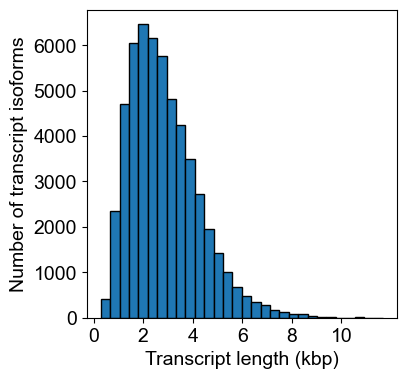

In [14]:

# Plot the distribution of transcript lengths 
def plot_length_of_trans(sqanti_info):
    fig, ax = plt.subplots(figsize=(4,4))
    ax = plt.hist(sqanti_info.len, bins=30, edgecolor='black')
    plt.xticks(ticks=[0,2000,4000,6000,8000,10000], labels=[0,2,4,6,8,10])
    plt.xlabel('Transcript length (kbp)')
    plt.ylabel('Number of transcript isoforms')
    plt.savefig('plot/04_distr_of_transcript_lengths.pdf', bbox_inches='tight')
    plt.show()
    plt.clf()
    (sqanti_info
        .filter(items=['pb_acc', 'gene', 'len'])
        .to_csv('stats/04_distr_of_transcript_lengths.tsv', sep='\t', index=None)
    )
plot_length_of_trans(sqanti_info)


In [10]:
#find the average length of the PB-derived transcripts
avg_length = sqanti_info['len'].mean()
avg_length

2846.429664147931


### Plot the transcriptional abundances for all transcript isoforms with cpm >1


<Figure size 640x480 with 0 Axes>

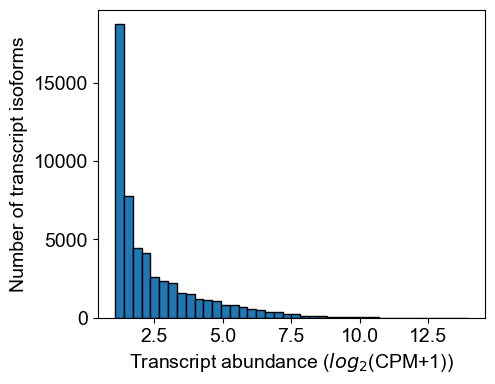

In [11]:

def plot_transcriptional_abundances(sqanti_info): 
    sqanti_info_cpm_1 = sqanti_info[sqanti_info.cpm > 1]
    fig, ax = plt.subplots(figsize=(5,4))
    plt.hist(sqanti_info_cpm_1.log2cpm, bins = 40,  edgecolor = 'black')
    plt.xlabel('Transcript abundance ($log_2$(CPM+1))')
    plt.ylabel('Number of transcript isoforms')
    plt.savefig('plot/transcript_abund_all_data.pdf', bbox_inches='tight')
    plt.show()
    plt.clf()
    (sqanti_info_cpm_1
        .filter(items=['pb_acc', 'log2cpm'])
        .rename(columns={'log2cpm': 'log2cpm+1',
                        'pb_acc': 'pb_acc'})
        .to_csv('stats/transcript_abund_all_data.tsv', sep='\t', index=None)
    )
plot_transcriptional_abundances(sqanti_info)




### Plot the distribution of the number of isoforms per number of genes (hint to multiple isoform diversity)


<Figure size 640x480 with 0 Axes>

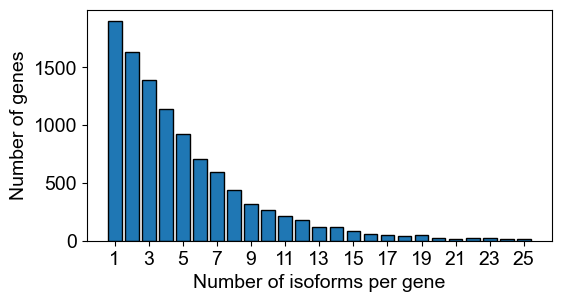

In [12]:

def plot_iso_per_gene(sqanti_info, cpm_threshold):
    over_N_cpm = sqanti_info[sqanti_info['cpm'] > cpm_threshold]
    over_N_genes = over_N_cpm.groupby('gene').size().reset_index()
    over_N_genes.columns = ['gene', 'num_transcripts']
    max_t = over_N_genes['num_transcripts'].max()
    over_group = over_N_genes.groupby("num_transcripts").size()
    for i in range(1, max_t): 
        if i not in over_group.index:
            over_group.at[i] = 0 ###confused how this is working 
    over_group = over_group.reset_index().sort_values(by = 'num_transcripts')
    fig, ax = plt.subplots(figsize = (6,3)) 
    plt.bar(range(1, 26), over_group[0][:25], edgecolor='black')
    plt.xticks(range(1, 26, 2))
    plt.xlabel('Number of isoforms per gene')
    plt.ylabel("Number of genes")
    plt.savefig('plot/hist_num_isoform_per_gene_min1cpm.pdf', bbox_inches='tight')
    plt.show()
    plt.clf()
    (over_group
        .rename(columns={'num_transcripts':'num_transcripts_per_gene',
                        0: 'num_genes'})
        .to_csv('stats/hist_num_isoform_per_gene_min1cpm.tsv', sep='\t', index=None)
    )
plot_iso_per_gene(sqanti_info, cpm_threshold=1)


In [18]:


#%%
#################
# SQANTI analysis
# ################
# plot the distribution of the transcripts as SQANTI cats inclusive of all the data
sqanti_info_copy = sqanti_info
sqanti_info_copy = sqanti_info_copy.replace(to_replace=['FSM', 'NNC', 'NIC'], value= 'All')

#merge the 2 data frames so that we csn get the distribution of all the cats
merged = pd.concat([sqanti_info_copy, sqanti_info], axis = 0)




### Plot the transcriptional abundances for the different SQANTI categories 


<Figure size 640x480 with 0 Axes>

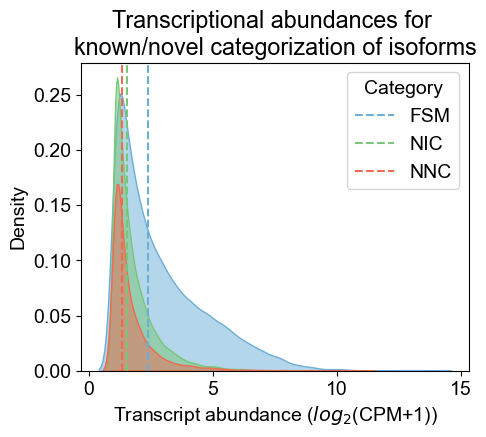

In [20]:
 
def sqanti_overlay_hist(sqanti_info):
    fig, ax = plt.subplots(figsize=(5, 4))
    order_list = ['NNC', 'NIC', 'FSM']
    sns.kdeplot(data= sqanti_info, x= 'log2cpm',  hue= 'cat', fill = True, common_norm= True, palette= huvec_config.sqanti_colors, alpha = .5, hue_order= order_list, legend= False)
    ax.set_ylabel('Density', fontsize = 14)
    ax.set_xlabel('Transcript abundance ($log_2$(CPM+1))', fontsize =14)
    plt.axvline(x=fsm_median,color='#6BAED6', linestyle='--')
    plt.axvline(x = nic_median, color = '#78C679', linestyle = '--')
    plt.axvline(x=nnc_median, color = '#EE6A50', linestyle = '--')
    plt.title('Transcriptional abundances for \nknown/novel categorization of isoforms')
    plt.legend(title='Category', loc='upper right', labels=['FSM', 'NIC', 'NNC'], fontsize = 14, title_fontsize='14')
    plt.savefig('plot/density_plots_SQANTI_cats_known_novel_title.pdf', bbox_inches = 'tight')
    plt.show()
    plt.clf()
sqanti_overlay_hist(sqanti_info) 
#%%

